In [6]:
import pandas as pd
import plotly.express as px
import numpy as np
import threading
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup
import seaborn as sns
import matplotlib.pyplot as plt
import os
import umap
import matplotlib.pyplot as plt
import glob

In [7]:
all_tweets=pd.read_csv("original_tweets_cleaned.csv")

In [15]:
model=torch.load("emotion_sentiment.pt").to("cuda:0")
labels_mapping={'sadness': 4, 'joy': 2, 'anger': 0, 'fear': 1, 'surprise': 5}
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)


C:\Users\akshe\Miniconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'transformers.modeling_bert.BertSelfAttention' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [8]:
location=[i for i in [str(i) for i in all_tweets.location.unique()] if ("ncr" in i.lower()) or ("delhi" in i.lower())]
time=[]
full_text=[]
for i in range(0,len(all_tweets.index)):
    if all_tweets.location.values[i] in location:
        time.append(all_tweets.created_at.values[i])
        full_text.append(all_tweets.full_text.values[i])
delhi=pd.DataFrame()
delhi["Timeline"]=time
delhi["Text"]=full_text
delhi=delhi.sort_values("Timeline")
delhi.index=pd.to_datetime(delhi.Timeline)
delhi_tweets=delhi.drop("Timeline",axis=1)

In [9]:
delhi_tweets=delhi_tweets.drop_duplicates()
march_delhi_tweets=list(delhi_tweets[delhi_tweets.index.month==3].Text.values)

In [29]:
def days_to_week_sorter(twitter):
        tweets=[]
        timeline=[]
        weekly_df=pd.DataFrame()
        index=[]
        for week in twitter.index.week.unique():
                this_weeks_data = twitter[twitter.index.week == week]
                tweets.append([str(this_weeks_data.Text.values[i]) for i in range(len(this_weeks_data.Text.values))])
                timeline.append(str(this_weeks_data.index[0])+"-"+str(this_weeks_data.index[-1]))
                index.append(str(this_weeks_data.index[0]))
        weekly_df["timeline"]=timeline
        weekly_df["tweets"]=tweets
        weekly_df.index=index
        return weekly_df

In [30]:
delhi_weekly_tweets=days_to_week_sorter(delhi_tweets)

In [31]:
#these functions are used to fit tweets to emotions
def emotion_classifier(text):
    test_data=tokenizer.encode_plus(
      text,
      max_length=128,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    pred=model(test_data["input_ids"].to("cuda:0"),test_data["attention_mask"].to("cuda:0"))[0].to("cpu").detach().numpy()
    return np.argmax(pred)
def emotion_postproc_p(news_emotions,emotion):
    number_of_emotion_week=[]
    for i in news_emotions:
        emotion_count_this_week=0
        for j in i:
            if j==emotion:
                emotion_count_this_week+=1
        number_of_emotion_week.append((emotion_count_this_week/len(i))*100)
    return number_of_emotion_week
def emotion_postproc(news_emotions,emotion):
    number_of_emotion_week=[]
    for i in news_emotions:
        emotion_count_this_week=0
        for j in i:
            if j==emotion:
                emotion_count_this_week+=1
        number_of_emotion_week.append(emotion_count_this_week)
    return number_of_emotion_week
def god_function(city,city_name):
    news_emotions=[[emotion_classifier(j) for j in i] for i in city.tweets.values]
    city["fear_percentage"]=emotion_postproc_p(news_emotions,1)
    city["anger_percentage"]=emotion_postproc_p(news_emotions,0)
    city["sadness_percentage"]=emotion_postproc_p(news_emotions,4)
    city["joy_percentage"]=emotion_postproc_p(news_emotions,2)
    city["surprise_percentage"]=emotion_postproc_p(news_emotions,5)
    city["fear"]=emotion_postproc(news_emotions,1)
    city["anger"]=emotion_postproc(news_emotions,0)
    city["sadness"]=emotion_postproc(news_emotions,4)
    city["joy"]=emotion_postproc(news_emotions,2)
    city["surprise"]=emotion_postproc(news_emotions,5)
    city.to_csv(str(city_name)+"-tweets-emotions.csv")
    return city

In [32]:
delhi_tweets_emotions=god_function(delhi_weekly_tweets,"delhi")

In [33]:
delhi_tweets_emotions

,timeline,tweets,fear_percentage,anger_percentage,sadness_percentage,joy_percentage,surprise_percentage,fear,anger,sadness,joy,surprise
2020-01-22 09:10:07+00:00,2020-01-22 09:10:07+00:00-2020-01-26 23:53:41+...,[China issues travel advisory after deaths due...,55.153203,13.091922,5.710306,25.208914,0.557103,396,94,41,181,4
2020-01-27 00:43:43+00:00,2020-01-27 00:43:43+00:00-2020-02-02 23:39:57+...,"[Tibets Potala Palace, Dalai Lamas official re...",35.705430,24.249938,8.108108,31.242251,0.223159,1440,978,327,1260,9
2020-02-03 00:46:36+00:00,2020-02-03 00:46:36+00:00-2020-02-09 23:18:00+...,[central BANK OF CHINA has decided to put in 1...,28.333949,28.629479,10.232730,31.954193,0.221648,767,775,277,865,6
2020-02-10 00:22:18+00:00,2020-02-10 00:22:18+00:00-2020-02-16 23:50:43+...,[Worry over coronavirus travel restrictions ke...,27.143895,27.289244,9.992733,34.920058,0.145349,747,751,275,961,4
2020-02-17 00:06:01+00:00,2020-02-17 00:06:01+00:00-2020-02-22 20:30:01+...,[World must stop /close their mfgr plant of an...,26.906361,27.261952,10.075069,34.887396,0.197550,681,690,255,883,5
2020-02-24 04:03:04+00:00,2020-02-24 04:03:04+00:00-2020-03-01 23:54:06+...,[Missed the fact that the Chinese Embassy in K...,28.353909,26.543210,9.382716,34.938272,0.329218,689,645,228,849,8
2020-03-02 00:15:04+00:00,2020-03-02 00:15:04+00:00-2020-03-08 23:45:01+...,"[Man who died in Kochi tests -ve for Covid-19,...",30.143014,24.673896,6.899261,37.356593,0.314317,1918,1570,439,2377,20
2020-03-09 00:34:47+00:00,2020-03-09 00:34:47+00:00-2020-03-15 23:58:39+...,[Chinas open air meat markets linked to H1N1 a...,24.200278,26.425591,10.431154,37.830320,0.486787,348,380,150,544,7
2020-03-16 01:25:54+00:00,2020-03-16 01:25:54+00:00-2020-03-22 23:46:27+...,[This is not right . Social isolation doesnt m...,15.978078,28.920742,8.010118,45.994941,0.295110,379,686,190,1091,7
2020-03-23 00:08:52+00:00,2020-03-23 00:08:52+00:00-2020-03-29 23:56:25+...,[plz take quick action as below also.. Proper ...,12.998713,32.196482,10.982411,42.449592,0.321750,606,1501,512,1979,15


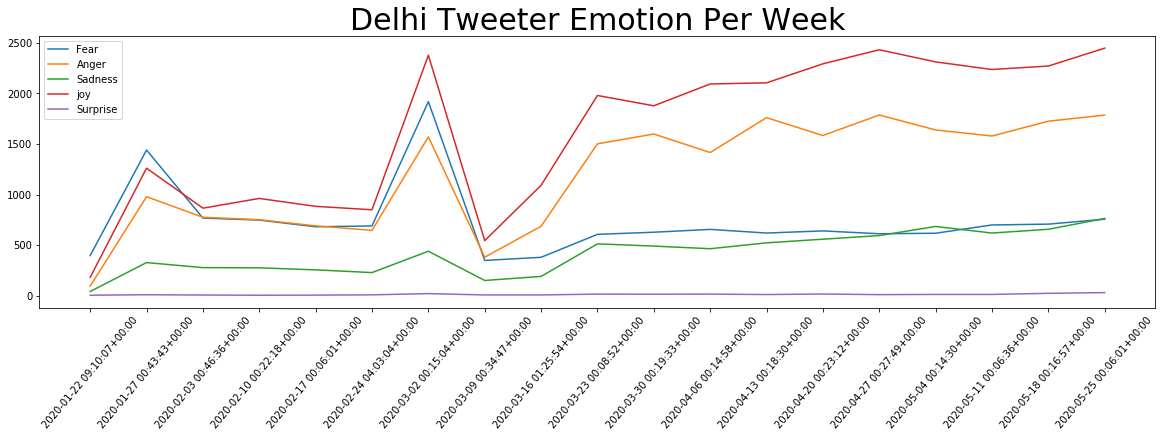

In [34]:
plt.figure(figsize=(20,5))
plt.plot(delhi_tweets_emotions.index,delhi_tweets_emotions.fear)
plt.xticks(rotation=50)
plt.plot(delhi_tweets_emotions.index,delhi_tweets_emotions.anger)
plt.plot(delhi_tweets_emotions.index,delhi_tweets_emotions.sadness)
plt.plot(delhi_tweets_emotions.index,delhi_tweets_emotions.joy)
plt.plot(delhi_tweets_emotions.index,delhi_tweets_emotions.surprise)
plt.legend(["Fear","Anger","Sadness","joy","Surprise"])
plt.title("Delhi Tweeter Emotion Per Week",fontsize=30)
plt.savefig("delhi-emotion.png")

(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 <a list of 10 Text xticklabel objects>)

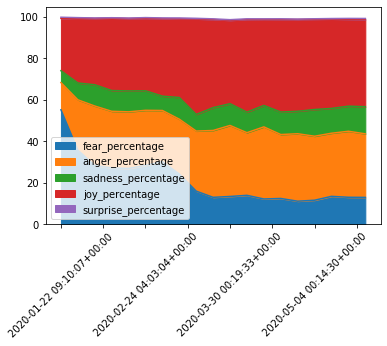

In [35]:
delhi_tweets_emotions.drop(["fear","anger","sadness","joy","surprise"],axis=1).plot.area()
plt.xticks(rotation=45)